# Задание 2. Построение тренд-сезонной модели

In [6]:
import os
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

In [7]:
from pandas import read_csv
df = read_csv('task2.csv',parse_dates = True, index_col = 0,delimiter=';',decimal=',')
df.head()

,Рыночные цены на материал 2 (руб.)
Дата,
2007-01-01,4.22
2007-02-01,3.99
2007-03-01,4.05
2007-04-01,4.34
2007-05-01,4.63


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Рыночные цены на материал 2 (руб.)  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [9]:
# Переименование столбцов
df_columns, df.columns = df.columns, ('y', )
df_index, df.index.name = df.index.name, 'date'
df.head()

,y
date,
2007-01-01,4.22
2007-02-01,3.99
2007-03-01,4.05
2007-04-01,4.34
2007-05-01,4.63


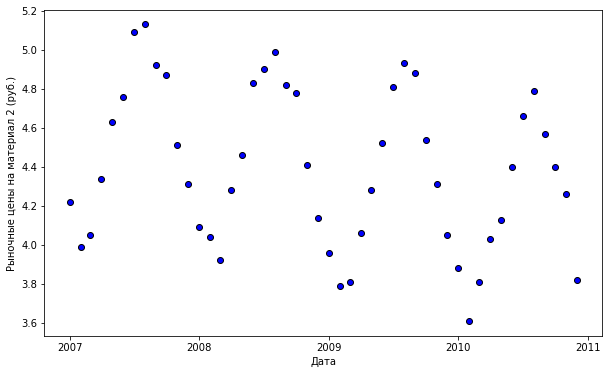

In [10]:
# Визуализация данных с надписями
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 6))

plt.xlabel(df_index)
plt.ylabel(df_columns[0])

ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))

ax.plot(df['y'], marker = 'o', color = (0, 0, 0, 0), markerfacecolor = 'blue')
    
plt.show()

In [12]:
# Добавляем вспомогательный столбец t
import numpy as np
df['t'] = np.arange(1, len(df) + 1)
df.head()

,y,t
date,,
2007-01-01,4.22,1
2007-02-01,3.99,2
2007-03-01,4.05,3
2007-04-01,4.34,4
2007-05-01,4.63,5


In [13]:
# Найдем коэффициенты уравнения тренда
import numpy as np
coef = np.polyfit(df['t'], df['y'], deg = 1)
coef

array([-0.00648176,  4.55005319])

In [14]:
# Найдем расчетные значения по уравнению тренда
df['y^'] = coef[0] * df['t'] + coef[1]
df['y^'].head()

date
2007-01-01    4.543571
2007-02-01    4.537090
2007-03-01    4.530608
2007-04-01    4.524126
2007-05-01    4.517644
Name: y^, dtype: float64

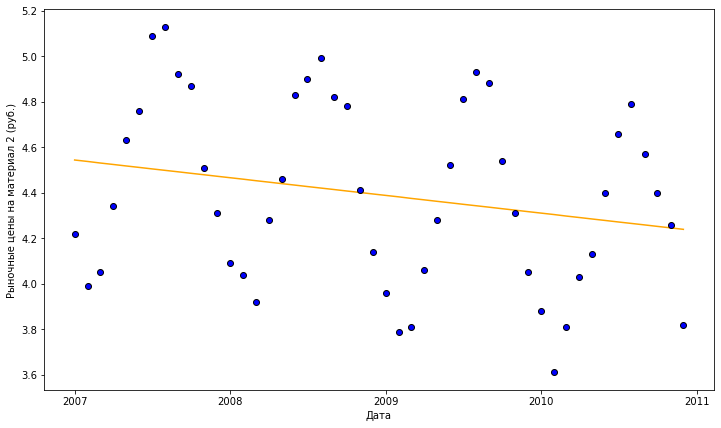

In [15]:
# Изобразим на графике фактические значения и расчетные по тренду
fig, ax = plt.subplots(figsize = (12, 7))

plt.xlabel(df_index)
plt.ylabel(df_columns[0])

ax.plot(df['y^'], color = 'orange')

ax.plot(df['y'], marker = 'o', color = (0, 0, 0, 0), markerfacecolor = 'blue')

ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
    
plt.show()

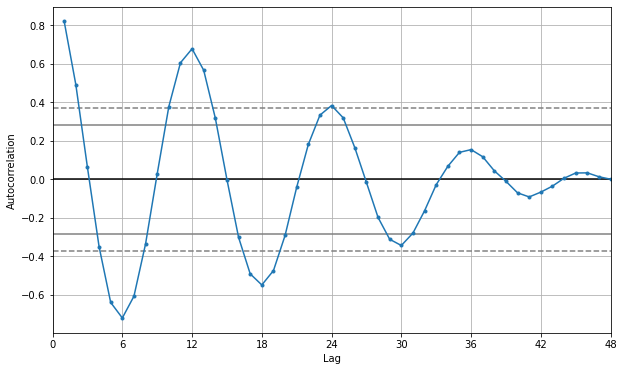

In [16]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(df['y'], ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(6))
ax.set_xlim(0, 48)

plt.show()

#### По графику автокорреляции для ряда данных можно предположить, что лаг сезонности равен 12

### Построим аддитивную тренд-сезонную модель

In [18]:
import pandas as pd
s = 12
ses = (df['y']-df['y^'])
ses = np.array([np.mean(ses.iloc[k::s]) for k in range(s)])
ses = pd.DataFrame(ses - np.mean(ses), index = np.arange(1, s + 1))
ses

,0
1,-0.389400
2,-0.562918
3,-0.516436
4,-0.229954
5,-0.025973
6,0.233009
7,0.476991
8,0.578473
9,0.422454
10,0.278936


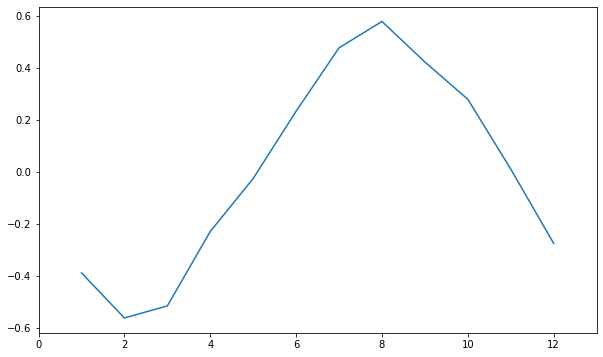

In [19]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.set_xlim(0, s + 1)
plt.plot(ses)
plt.show()

In [20]:
tmp = pd.concat([ses for _ in range(4)], ignore_index = True)
tmp.index = df.index

df['s'] = tmp
df['y^s'] = df['y^'] + df['s']

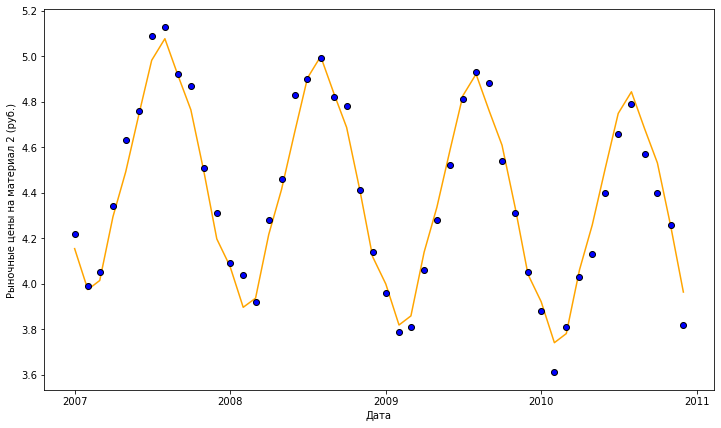

In [21]:
fig, ax = plt.subplots(figsize = (12, 7))

plt.xlabel(df_index)
plt.ylabel(df_columns[0])

ax.plot(df['y^s'], color = 'orange')

ax.plot(df['y'], marker = 'o', color = (0, 0, 0, 0), markerfacecolor = 'blue')

ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
    
plt.show()

### Строим точечный и интервальный прогноз

In [22]:
n = len(df)

x = np.arange(48, 60)

df_fv = pd.DataFrame({'y' : coef[0] * x + coef[1] + df['s'].iloc[:12].array}, index = pd.date_range(start = df.index[-1] + np.timedelta64(1, 'M'), 
                                    end   = df.index[-1] + np.timedelta64(13, 'M'), 
                                    freq  = 'MS'))

#### Условная дисперсия, СКО:

In [24]:
variance = np.sum(np.power(df['y'] - df['y^s'], 2)) / (n-1)
sigma =np.power(variance,0.5)
sigma

0.07706022013768304

In [25]:
from scipy.stats import t
tstud=t.interval(0.95, len(df)-1)
list(tstud)

[-2.0117405104757546, 2.0117405104757546]

In [26]:
lower=list(tstud)[0]*sigma
lower

-0.1550251665971565

In [27]:
upper=list(tstud)[1]*sigma
upper

0.1550251665971565

In [28]:
df_fv['y-'] = df_fv['y'] + lower
df_fv['y+'] = df_fv['y'] + upper

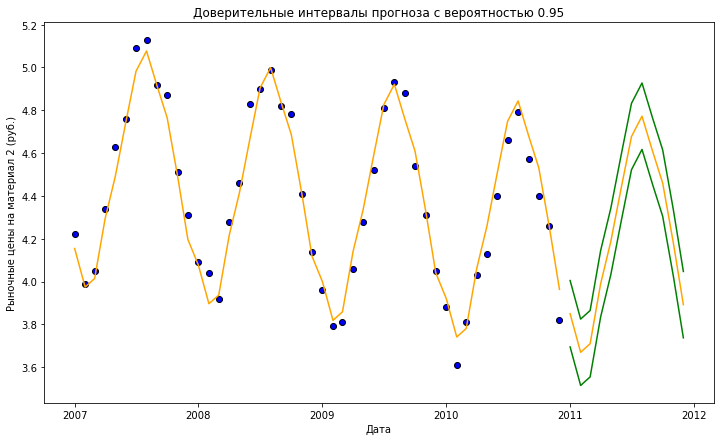

In [30]:
fig, ax = plt.subplots(figsize = (12, 7))

plt.title('Доверительные интервалы прогноза с вероятностью 0.95')
plt.xlabel(df_index)
plt.ylabel(df_columns[0])

ax.plot(df_fv['y-'], color = 'green')
ax.plot(df_fv['y'],  color = 'orange')
ax.plot(df_fv['y+'], color = 'green')

ax.plot(df['y'], marker = 'o', color = (0, 0, 0, 0), markerfacecolor = 'blue')
ax.plot(df['y^s'], color = 'orange')

ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
    
plt.show()

#### Коэффициент детерминации:

In [31]:
1 - np.sum(np.power(df['y'] - df['y^s'], 2)) / np.sum(np.power(df['y'] - np.mean(df['y']), 2))

0.9633551556951149